# (phase 2) 05 Domain adaptation

There are three main techniques for domain adaptation tackled in this study:
- Feature selection based on domain knowledge
- Instance reweighthing
- Label shift mitigation

Other techiques have been tried (refer to notebooks/transfer_learning_domain_adaptation.ipynb) but this notebooks shows exclusively those resulting in a positive impact in domain adaptation. Transfer learning techniques are not as advanced in tabular settings as they are in image or language data. However, they result effective in the specific case we are working with.

- 0. Baseline model
- 1. Model 1 - feature selecion based on domain knowledge
- 2. Model 2 - instance reweighting
- 3. Model 3 - label shift mitigation
- 4. Model 4 - combination of all 3 techniques

## Load data and needed libraries

In [106]:
import os
import numpy as np
import pandas as pd
import importlib
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc, accuracy_score, precision_score, recall_score
import prince
from joblib import dump, load

# import from custom package
from auxFuns.EDA import *
from auxFuns.modelling import *
from auxFuns.class_overlap import *
from auxFuns.transfer_learning import *

In [2]:
import auxFuns.EDA 
importlib.reload(auxFuns.EDA)

import auxFuns.modelling
importlib.reload(auxFuns.modelling)

import auxFuns.class_overlap
importlib.reload(auxFuns.class_overlap)

import auxFuns.transfer_learning
importlib.reload(auxFuns.transfer_learning)

<module 'auxFuns.transfer_learning' from 'c:\\Users\\angel\\Documents\\VSCode\\rsv_modelling_transfer_learning\\auxFuns\\transfer_learning.py'>

In [3]:
# Load of the data and filter in the needed features

raw_datasets_path = os.getcwd() + '/datasets/raw'
processed_datasets_path = os.getcwd() + '/datasets/processed'

# Phase 1 data
rsv_predictors_df_v2 = pd.read_csv(processed_datasets_path + '/rsv_predictors_phase1_daysDedup_seasons_prevTest_v2.csv',low_memory=False)
rsv_predictors_phase1_df = make_it_categorical_v2(rsv_predictors_df_v2)

# Phase 2 data
rsv_phase2_df = pd.read_csv(processed_datasets_path + '/rsv_phase2_all_features.csv',low_memory=False)
rsv_phase2_df = make_it_categorical_v2(rsv_phase2_df, is_phase1 = False)

# Small subset of labelled data of phase 2:
labels_phase2_df = pd.read_csv(raw_datasets_path + '/rsv_test_phase2.csv',low_memory=False)
labels_phase2_df = labels_phase2_df.rename(columns = {'RSV_test_date':'index_date'})

# Compatibility issue detected: merging labelled and unlabelled data is challening due to incompatible date columns
rsv_phase2_df.index_date = pd.to_datetime(rsv_phase2_df.index_date)
labels_phase2_df.index_date = pd.to_datetime(labels_phase2_df.index_date)

rsv_phase2_labelled_df = labels_phase2_df.merge(rsv_phase2_df, how='left', on=['patient_id', 'index_date'])
# rsv_phase2_labelled_df = labels_phase2_df.merge(rsv_phase2_df, how='left', on=['patient_id'])
rsv_phase2_labelled_df = rsv_phase2_labelled_df.dropna()

rsv_predictors_phase1_df.shape, rsv_phase2_df.shape, rsv_phase2_labelled_df.shape

((86058, 64), (291938, 63), (2867, 64))

In [5]:
selected_features = ['sex', 'marital_status', 'race','patient_regional_location', 'age_group',
                     'Acute_upper_respiratory_infection','Influenza','Pneumonia','Bronchitis','Symptoms_and_signs__digestive_system_and_abdomen','General_symptoms_and_signs','any_symptom',
                     'COPD','AIDS','Asthma_chronic','CCI',
                     'sine','cosine','calendar_year', 
                     'healthcare_seeking', 'influenza_vaccine',
                     'n_symptoms','prev_positive_rsv','previous_test_daydiff','n_immunodeficiencies', 
                     'tumor_indicator','tumor_last_year',
                     'season',
                     'n_tests_that_day']
selected_features_v1 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'season','multiple_tests']
selected_features_v2 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'key_comorbidities','Pneumonia',
                     'season','month_of_the_test','multiple_tests',
                     'BPA','BPAI']
selected_features_v3 = selected_features_v2 + ['race', 'age_group','marital_status','sex',
                                                    'patient_regional_location','calendar_year']

selected_features_v2_aux = selected_features_v2.copy()
selected_features_v1.append('RSV_test_result')
selected_features_v2.append('RSV_test_result')
selected_features_v3.append('RSV_test_result')

In [7]:
df_modelling_phase1 = rsv_predictors_phase1_df[selected_features_v2]
df_modelling_phase2 = rsv_phase2_labelled_df[selected_features_v2]
df_modelling_all_phase2 = rsv_phase2_df[selected_features_v2_aux]

df_modelling_phase1.shape, df_modelling_phase2.shape, df_modelling_all_phase2.shape

# differentiate between labelled and non-labelled data in phase 2
labelled_data_phase2_mask = rsv_phase2_labelled_df.index
labelled_mask = rsv_phase2_df.index.isin(labelled_data_phase2_mask)
non_labelled_mask = ~rsv_phase2_df.index.isin(labelled_data_phase2_mask)

df_modelling_phase2_labelled = df_modelling_phase2.copy()
df_modelling_phase2_nonlabelled = df_modelling_all_phase2.loc[non_labelled_mask,:]

df_modelling_phase1.shape, df_modelling_phase2_labelled.shape, df_modelling_phase2_nonlabelled.shape

((86058, 21), (2867, 21), (289071, 20))

In [11]:
# Definition of X_target, y_target, X_source, y_source for clarity

# Phase 1 is the 'source' population
X_source = df_modelling_phase1.drop(['RSV_test_result'], axis = 1)
y_source = df_modelling_phase1.RSV_test_result

# Phase 1 is the 'target' population
X_target = df_modelling_phase2_labelled.drop(['RSV_test_result'], axis = 1)
y_target = df_modelling_phase2_labelled.RSV_test_result

X_source.shape, y_source.shape, X_target.shape, y_target.shape

((86058, 20), (86058,), (2867, 20), (2867,))

## 0. Baseline model

Implementation of the model validated in source data directly in the target population.

In [102]:
# 0.1 Loading the previously-validated models from phase 1
phase1_models_path = os.getcwd() + '/models/models_phase1'

model_nonOverlapping_phase1 = joblib.load(phase1_models_path + '/nonOverlapping_rfc_8020_20230903.joblib')
model_Overlapping_phase1 = joblib.load(phase1_models_path + '/Overlapping_rfc_8020_20230903.joblib')

# 0.2 Division of phase 2 population into overlapping and non-overlapping regions
X_test_phase2 =  pd.get_dummies(X_target)

same_class_neighbours_phase2_dict, __, __, __ = calculate_same_neighbours_and_N1(X_test_phase2 ,y_target, n_neighbours = 2)
same_class_neighbours_phase2 = same_class_neighbours_phase2_dict[1]

X_test_phase2_nonOverlapping = X_test_phase2.loc[same_class_neighbours_phase2 == True,:]
X_test_phase2_Overlapping = X_test_phase2.loc[same_class_neighbours_phase2 == False,:]

y_test_phase2_nonOverlapping = y_target.loc[same_class_neighbours_phase2 == True]
y_test_phase2_Overlapping = y_target.loc[same_class_neighbours_phase2 == False]

# 0.2 Performance metrics of the phase 1 model in phase 2 population
preds_proba_nonOverlapping = model_nonOverlapping_phase1.predict_proba(X_test_phase2_nonOverlapping)[:,1]
preds_proba_Overlapping = model_Overlapping_phase1.predict_proba(X_test_phase2_Overlapping)[:,1]

print('\n----------------------------------')
print('Aggregated metrics on phase 2 population')
probs_all = np.concatenate([preds_proba_nonOverlapping, preds_proba_Overlapping], axis = 0)
y_test_all = pd.concat([y_test_phase2_nonOverlapping,y_test_phase2_Overlapping], axis = 0)

optimal_thr_all = find_optimal_moving_threshold_from_probas(probs_all, y_test = y_test_all)
roc_auc_0, __, __, __, __, __, __, pr_auc_0, fpr_0, tpr_0,recalls_0,precisions_0 = calculate_performance_metrics_from_probas(y_probs = probs_all, y_test = y_test_all, 
                                                                            threshold = optimal_thr_all, print_roc = False, print_pr = False)

Build-up of the ball tree ...
Finding closest 1 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.029647715381932338
Done!

----------------------------------
Aggregated metrics on phase 2 population
Optimal threshold: 0.04
Optimal f1: 0.07917656373713382


AUC Score: 0.7105649678917885
Precision / Positive predictive value: 0.04128819157720892
Specificity: 0.5875666074600355
Recall / sensitivity: 0.9615384615384616
Negative predictive value: 0.998792270531401
Accuracy: 0.5943494942448553
F-1: 0.07917656373713382
Precision-Recall AUC: 0.03754159143412433


The baseline model results in a very limited performance: 0.079 F1-score

## 1. Model 1 - feature selecion based on domain knowledge

In the context of our study, it is crucial to note the compositional differences between the Phase 1 and Phase 2 populations. Specifically, Phase 1 consists of patients who have undergone RSV testing, whereas Phase 2 comprises patients who merely show symptoms of the disease. Given these differences, there are three features that may not be pertinent for inclusion in the modeling endeavors targeted at the Phase 2 population.:

['n_tests_that_day', 'previous_test_daydiff', 'multiple_tests']


In [17]:
# 1.1 Drop those features and fit a new model built on the newly selected subset of predictors
rsv_test_related_features = ['n_tests_that_day', 'previous_test_daydiff', 'multiple_tests']

X_source_model1 = X_source.drop(rsv_test_related_features, axis = 1)
X_target_model1 = X_target.drop(rsv_test_related_features, axis = 1)

In [19]:
# 1.2 Find the overlapping and non-overlapping regions in both source and target domains
X_source_model1_dummies = pd.get_dummies(X_source_model1)
X_target_model1_dummies = pd.get_dummies(X_target_model1)

print('Overlapping in regions in source domain...')
same_class_neighbours_source_1, __, __, __ = calculate_same_neighbours_and_N1(X = X_source_model1_dummies, y = y_source, n_neighbours = 2)

print('\nOverlapping in regions in target domain...')
same_class_neighbours_target_1, __, __, __ = calculate_same_neighbours_and_N1(X = X_target_model1_dummies, y = y_target, n_neighbours = 2)


Overlapping in regions in source domain...
Build-up of the ball tree ...
Finding closest 4 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.05484673127425688
N1 metric for 2 neighbours : 0.08233981733249673
N1 metric for 3 neighbours : 0.10346510492923378
N1 metric for 4 neighbours : 0.1254735178600479
Done!

Overlapping in regions in target domain...
Build-up of the ball tree ...
Finding closest 4 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.026159748866410926
N1 metric for 2 neighbours : 0.0435995814440181
N1 metric for 3 neighbours : 0.06278339727938609
N1 metric for 4 neighbours : 0.07673526334147196
Done!


In [20]:
# 1.3 Build a new model on source population, after removal of 3 conflicting predictors
overlapping_instances_source_1 = ~same_class_neighbours_source_1[1]

model_nonOverlapping_1, model_Overlapping_1 = only_build_2overlapping_models(X = X_source_model1_dummies, labels = y_source, is_overlapping = overlapping_instances_source_1, 
                                                                        random_seed = 42)

----------------
Building non-overlapping model ...
Training model ... RandomForestClassifier(class_weight={'Negative': 1, 'Positive': 15},
                       random_state=42)
Best training parameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 7}
Best training f1-score:  0.07249833891898537
----------------
Building (yes) overlapping model ...
Training model ... RandomForestClassifier(class_weight={'Negative': 1, 'Positive': 15},
                       random_state=42)
Best training parameters:  {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 14}
Best training f1-score:  0.5480495076490431


In [98]:
# 1.4. Evaluate the new model in the target domain
preds_proba_nonOverlapping = model_nonOverlapping_1.predict_proba(X_target_model1_dummies)[:,1]
preds_proba_Overlapping = model_Overlapping_1.predict_proba(X_target_model1_dummies)[:,1]

print('\n----------------------------------')
print('Aggregated metrics on phase 2 population')
overlapping_instances_target_1 =  ~same_class_neighbours_target_1[1]
probs_all = (preds_proba_nonOverlapping*(~overlapping_instances_target_1)) + (preds_proba_Overlapping*overlapping_instances_target_1)

optimal_thr_all = find_optimal_moving_threshold_from_probas(probs_all, y_test = y_target)
roc_auc_1, __, __, __, __, __, __, pr_auc_1, fpr_1, tpr_1,recalls_1,precisions_1 = calculate_performance_metrics_from_probas(y_probs = probs_all, y_test = y_target, 
                                                                            threshold = optimal_thr_all, print_roc = False, print_pr = False)


----------------------------------
Aggregated metrics on phase 2 population
Optimal threshold: 0.68
Optimal f1: 0.515625


AUC Score: 0.8723049596939474
Precision / Positive predictive value: 0.4342105263157895
Specificity: 0.9847246891651865
Recall / sensitivity: 0.6346153846153846
Negative predictive value: 0.9931924041562165
Accuracy: 0.978374607603767
F-1: 0.515625
Precision-Recall AUC: 0.3292506605907083


The improvement in performance is already very high!

## 2. Model 2 - instance reweighting
Instance reweighting by itself can be challenging. The main idea behind this approach is to assign a higher weight to instances in the source population that resemble those of the target population

We will follow the approach of using a discriminator to differentiate between phase 1 and phase 2 labelled data, and then use the prediction probabilities of that discriminator as weights.
1. Build a discriminator and compute the same-weights that will affect training of the model in phase 1 (output: source_instances_weights)
2. Train the model in phase 1 taking this source_instances_weights as sample weights in the model
3. Evaluate the retrained model in target data

In [22]:
X_combined = pd.concat([X_source, X_target], axis = 0)
labels_phase = np.hstack((np.zeros(len(X_source)), np.ones(len(X_target))))

In [26]:
# 2.1. Build the discriminator and compute the source_instance_weights
# i) build a classifier able to differentiate between phase 1 and phase 2 data
# ii) on the same set as the training, predict the probabilities to belonging to one or the other 
# iii) assign these probabilities as weights for the instance re-weighting process

# i: train a discriminator 
# a decision tree is chosen for its good performance in the domain shift quantification section 
discriminator = DecisionTreeClassifier().fit(pd.get_dummies(X_combined), labels_phase)

# Predict for all instances (X_combined) to evaluate performance
probs_discriminator = discriminator.predict_proba(pd.get_dummies(X_combined))[:, 1] # Probabilities for class 1 (being part of target population)
optimal_thr_discriminator = find_optimal_moving_threshold_from_probas(probs_discriminator, y_test = labels_phase, verbose=False)
y_pred_performance = probs_discriminator > optimal_thr_discriminator
accuracy_discriminator = accuracy_score(labels_phase, y_pred_performance)
recall_discriminator = recall_score(labels_phase, y_pred_performance)
precision_discriminator = precision_score(labels_phase, y_pred_performance)

print(f'Accuracy of the discriminator is: {accuracy_discriminator}')
print(f'Recall of the discriminator is: {recall_discriminator}')
print(f'Precision of the discriminator is: {precision_discriminator}')

# ii: predict the probabilities (for source data only, as we are interested in reweighting the instances of the source population)
probs_source = discriminator.predict_proba(pd.get_dummies(X_source))[:, 1] # Probabilities for class 1 (being part of target population)
probs_target = discriminator.predict_proba(pd.get_dummies(X_target))[:, 1]

# iii: define the weights for instance reweighting
source_instances_weights = probs_source / (1 - probs_source)
target_instances_weights = probs_target / (1.01 - probs_target)

Accuracy of the discriminator is: 0.9137587854933933
Recall of the discriminator is: 1.0
Precision of the discriminator is: 0.27211465451784356


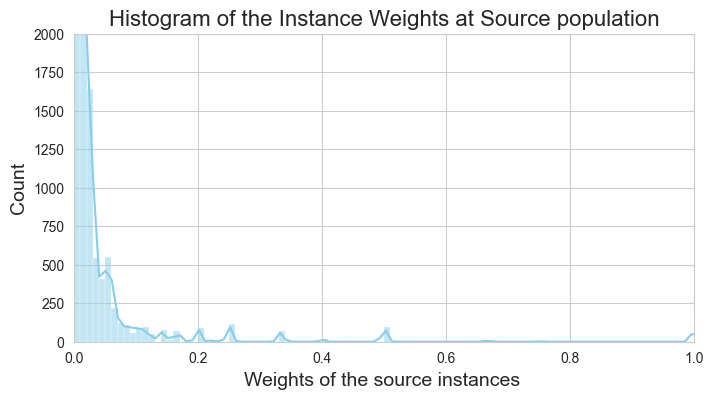

In [47]:
# Histogram for visualization of the final weights
weights = source_instances_weights[source_instances_weights >= 0]

sns.set_style("whitegrid")
sns.set_palette("muted")

plt.figure(figsize=(8,4))
sns.histplot(weights, bins=200, kde=True, color='skyblue')

plt.title('Histogram of the Instance Weights at Source population', fontsize=16)
plt.xlabel('Weights of the source instances ', fontsize=14)
plt.ylabel('Count', fontsize=14)
# plt.gca().set_yscale("log")

plt.xlim([0,1]), plt.ylim([0,2000])
plt.show()

In [48]:
# 2.2. Determine overlapping and non-overlapping instances in source and target, this time with all features considered
# 1.2 Find the overlapping and non-overlapping regions in both source and target domains
X_source_models23_dummies = pd.get_dummies(X_source)
X_target_models23_dummies = pd.get_dummies(X_target)

print('Overlapping in regions in source domain...')
same_class_neighbours_source_23, __, __, __ = calculate_same_neighbours_and_N1(X = X_source_models23_dummies, y = y_source, n_neighbours = 2)

print('\nOverlapping in regions in target domain...')
same_class_neighbours_target_23, __, __, __ = calculate_same_neighbours_and_N1(X = X_target_models23_dummies, y = y_target, n_neighbours = 2)

Overlapping in regions in source domain...
Build-up of the ball tree ...
Finding closest 1 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.045504194845336854
Done!

Overlapping in regions in target domain...
Build-up of the ball tree ...
Finding closest 1 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.029647715381932338
Done!


In [50]:
# 2.3. Train the model in phase 1 including the instances weights calculated previously
# Train the overlapping and non-overlapping models in phase 1 (source) data. Add the source_instance weights identified previously
print('\n------------------')
print(f'Fitting of the phase 1 model following Instance Reweighting')
# Let us also add the source_instances_weights as feature for the model:
X_source_model2 = X_source_models23_dummies.copy()
X_source_model2['domain_likeliness_to_phase2'] = source_instances_weights

overlapping_instances_source_23 = ~same_class_neighbours_source_23[1]

source_instances_weights_non_overlapping = source_instances_weights[~overlapping_instances_source_23]
source_instances_weights_overlapping = source_instances_weights[overlapping_instances_source_23]


model_nonOverlapping_2, model_Overlapping_2 = only_build_2overlapping_models(X = X_source_model2, labels = y_source, is_overlapping = overlapping_instances_source_23,
                                                                        random_seed = 42,
                                                                        sample_weights_Overlapping = source_instances_weights_overlapping, 
                                                                        sample_weights_nonOverlapping = source_instances_weights_non_overlapping)


------------------
Fitting of the phase 1 model following Instance Reweighting
----------------
Building non-overlapping model ...
Training model ... RandomForestClassifier(class_weight={'Negative': 1, 'Positive': 15},
                       random_state=42)
Best training parameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 7}
Best training f1-score:  0.016492734152616213
----------------
Building (yes) overlapping model ...
Training model ... RandomForestClassifier(class_weight={'Negative': 1, 'Positive': 15},
                       random_state=42)
Best training parameters:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 7}
Best training f1-score:  0.5630929831342716


In [97]:
# 2.4. Evaluate the new model in the target domain, after instance reweighting
X_target_model2 = X_target_models23_dummies.copy()
X_target_model2['domain_likeliness_to_phase2'] = target_instances_weights

preds_proba_nonOverlapping = model_nonOverlapping_2.predict_proba(X_target_model2)[:,1]
preds_proba_Overlapping = model_Overlapping_2.predict_proba(X_target_model2)[:,1]

print('\n----------------------------------')
print('Aggregated metrics on phase 2 population (approach 2: instance reweighting)')
overlapping_instances_target_23 =  ~same_class_neighbours_target_23[1]
probs_all = (preds_proba_nonOverlapping*(~overlapping_instances_target_23)) + (preds_proba_Overlapping*overlapping_instances_target_23)

optimal_thr_all = find_optimal_moving_threshold_from_probas(probs_all, y_test = y_target)
roc_auc_2, __, __, __, __, __, __, pr_auc_2, fpr_2, tpr_2,recalls_2,precisions_2 = calculate_performance_metrics_from_probas(y_probs = probs_all, y_test = y_target, 
                                                                            threshold = optimal_thr_all, print_roc = False, print_pr = False)


----------------------------------
Aggregated metrics on phase 2 population (approach 2: instance reweighting)
Optimal threshold: 0.58
Optimal f1: 0.4827586206896552


AUC Score: 0.8571218745730291
Precision / Positive predictive value: 0.4375
Specificity: 0.9872113676731794
Recall / sensitivity: 0.5384615384615384
Negative predictive value: 0.9914377452729218
Accuracy: 0.9790722009068713
F-1: 0.4827586206896552
Precision-Recall AUC: 0.2985060412943161


Again, the performance has improved considerably! Approach number 2 is also a success in terms of domain adaptation

## 3. Model 3 - label shift mitigation
The RLLS method [5] spefically mitigates label shift. A simplified version of ti involves the following steps to take:

- 1. Estimate Source Label Distribution, in this case 3.0% positive and 97.0% negative.

- 2. Estimate Target Label Distribution: 1.8% positive and 98.2% negative.

- 3. Compute Importance Weights: Using the above distributions, compute the importance weights for each class, as indicated in the paper
​
- 4. Retrain the model on source domain including the importance weights 

- 5. Evaluate on Target Data


[5] Azizzadenesheli, K., Liu, A., Yang, F., & Anandkumar, A. (2019). Regularized learning for domain adaptation under label shifts. arXiv preprint arXiv:1903.09734.

In [88]:
# 3.0 Overlapping and non-overlapping regions are already determined by the previous step
np.unique(overlapping_instances_source_23, return_counts = True), np.unique(overlapping_instances_target_23, return_counts = True), 

((array([False,  True]), array([82142,  3916], dtype=int64)),
 (array([False,  True]), array([2782,   85], dtype=int64)))

In [89]:
# 3.3. Importance weights
# These importance weights are calculated per overlapping and non overlapping region too, not exclusively per domain and source

overlapping_labels_source = y_source [overlapping_instances_source_23]
non_overlapping_labels_source = y_source [~overlapping_instances_source_23]

overlapping_labels_target = y_target [overlapping_instances_target_23]
non_overlapping_labels_target = y_target [~overlapping_instances_target_23]

print(f'--- Value counts of overlapping areas: ---')
print(f'Source:\n{overlapping_labels_source.value_counts()}')
print(f'Target:\n{overlapping_labels_target.value_counts()}')
print(f'--- Value counts of nonoverlapping areas: ---')
print(f'Source:\n{non_overlapping_labels_source.value_counts()}')
print(f'Target:\n{non_overlapping_labels_target.value_counts()}')

# Computation of the importance weights for training of the model on phase 1 data
P_source_nonOverlapping_negative = non_overlapping_labels_source.value_counts()['Negative'] /(len(non_overlapping_labels_source))
P_source_nonOverlapping_positive =  non_overlapping_labels_source.value_counts()['Positive'] /(len(non_overlapping_labels_source))

P_source_Overlapping_negative = overlapping_labels_source.value_counts()['Negative'] /(len(overlapping_labels_source))
P_source_Overlapping_positive =  overlapping_labels_source.value_counts()['Positive'] /(len(overlapping_labels_source))

P_target_nonOverlapping_negative = non_overlapping_labels_target.value_counts()['Negative'] /(len(non_overlapping_labels_target))
P_target_nonOverlapping_positive =  non_overlapping_labels_target.value_counts()['Positive'] /(len(non_overlapping_labels_target))

P_target_Overlapping_negative = overlapping_labels_target.value_counts()['Negative'] /(len(overlapping_labels_target))
P_target_Overlapping_positive =  overlapping_labels_target.value_counts()['Positive'] /(len(overlapping_labels_target))

importance_weights_Overlapping_negative = P_target_Overlapping_negative / P_source_Overlapping_negative
importance_weights_Overlapping_positive = P_target_Overlapping_positive / P_source_Overlapping_positive
importance_weights_nonOverlapping_negative = P_target_nonOverlapping_negative / P_source_nonOverlapping_negative
importance_weights_nonOverlapping_positive = P_target_nonOverlapping_positive / P_source_nonOverlapping_positive

print(f'\n--- Importance weights of overlapping areas: ---')
print(f'Negative: {importance_weights_Overlapping_negative}')
print(f'Positive: {importance_weights_Overlapping_positive}')
print(f'---  Importance weights nonoverlapping areas: ---')
print(f'Negative: {importance_weights_nonOverlapping_negative}')
print(f'Positive: {importance_weights_nonOverlapping_positive}')

--- Value counts of overlapping areas: ---
Source:
Negative    2255
Positive    1661
Name: RSV_test_result, dtype: int64
Target:
Negative    45
Positive    40
Name: RSV_test_result, dtype: int64
--- Value counts of nonoverlapping areas: ---
Source:
Negative    81149
Positive      993
Name: RSV_test_result, dtype: int64
Target:
Negative    2770
Positive      12
Name: RSV_test_result, dtype: int64

--- Importance weights of overlapping areas: ---
Negative: 0.9193687230989956
Positive: 1.1094663030775225
---  Importance weights nonoverlapping areas: ---
Negative: 1.0078705235877177
Positive: 0.356812569365863


In [90]:
# 3.4.. Train the model in phase 1 including label shift mitigation method
# Train the overlapping and non-overlapping models in phase 1 (source) data. Add the class importance weights identified previously
print('\n------------------')
print(f'Fitting of the phase 1 model following Label shift mitigation')

model_nonOverlapping_3, model_Overlapping_3 = only_build_2overlapping_models(X = X_source_models23_dummies, labels = y_source, is_overlapping = overlapping_instances_source_23, 
                                                                        random_seed = 42,
                                                                        cost_sensitive_non_overlapping = True, weight_dict_non_overlapping = {'Negative': importance_weights_nonOverlapping_negative, 'Positive': importance_weights_nonOverlapping_positive},
                                                                        cost_sensitive_overlapping = True, weight_dict_overlapping = {'Negative': importance_weights_Overlapping_negative, 'Positive': importance_weights_Overlapping_positive}
                                                                        )


------------------
Fitting of the phase 1 model following Label shift mitigation
----------------
Building non-overlapping model ...
Training model ... RandomForestClassifier(class_weight={'Negative': 1.0078705235877177,
                                     'Positive': 0.356812569365863},
                       random_state=42)
Best training parameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 14}
Best training f1-score:  0.3989331271743332
----------------
Building (yes) overlapping model ...
Training model ... RandomForestClassifier(class_weight={'Negative': 0.9193687230989956,
                                     'Positive': 1.1094663030775225},
                       random_state=42)
Best training parameters:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 7}
Best training f1-score:  0.4699167815149094


In [96]:
# 3.5. Evaluation on he target domain
preds_proba_nonOverlapping = model_nonOverlapping_3.predict_proba(X_target_models23_dummies)[:,1]
preds_proba_Overlapping = model_Overlapping_3.predict_proba(X_target_models23_dummies)[:,1]

print('\n----------------------------------')
print('Aggregated metrics on phase 2 population (approach 3: label shift mitigation)')
overlapping_instances_target_23 =  ~same_class_neighbours_target_23[1]
probs_all = (preds_proba_nonOverlapping*(~overlapping_instances_target_23)) + (preds_proba_Overlapping*overlapping_instances_target_23)

optimal_thr_all = find_optimal_moving_threshold_from_probas(probs_all, y_test = y_target)
roc_auc_3, __, __, __, __, __, __, pr_auc_3, fpr_3, tpr_3,recalls_3,precisions_3 = calculate_performance_metrics_from_probas(y_probs = probs_all, y_test = y_target, 
                                                                            threshold = optimal_thr_all, print_roc = False, print_pr = False)


----------------------------------
Aggregated metrics on phase 2 population (approach 3: label shift mitigation)
Optimal threshold: 0.36
Optimal f1: 0.08631319358816276


AUC Score: 0.7303900806121055
Precision / Positive predictive value: 0.0461133069828722
Specificity: 0.7428063943161635
Recall / sensitivity: 0.6730769230769231
Negative predictive value: 0.9919354838709677
Accuracy: 0.7415416811998605
F-1: 0.08631319358816276
Precision-Recall AUC: 0.030650493952792842


In this case, the performance does increase, but the improvement is not as high as in approaches 1 and 2

## 4. Model 4 - combination of all 3 techniques
Now, is the moment to merge all the results of previous approaches

In [93]:
model_nonOverlapping_4, model_Overlapping_4 = only_build_2overlapping_models(
                                                                        # 1. Approach 1 is implemented by using this data, where the 3 conflicting features are removed
                                                                        X = X_source_model1_dummies, labels = y_source, is_overlapping = overlapping_instances_source_23, 
                                                                        random_seed = 42,
                                                                        # 2. Approach 2 includes the presence of instance reweighting
                                                                        sample_weights_Overlapping = source_instances_weights_overlapping, 
                                                                        sample_weights_nonOverlapping = source_instances_weights_non_overlapping,
                                                                        # 3. Approach 3: label mitigation via cost sensitive learning
                                                                        cost_sensitive_non_overlapping = True, weight_dict_non_overlapping = {'Negative': importance_weights_nonOverlapping_negative, 'Positive': importance_weights_nonOverlapping_positive},
                                                                        cost_sensitive_overlapping = True, weight_dict_overlapping = {'Negative': importance_weights_Overlapping_negative, 'Positive': importance_weights_Overlapping_positive}
                                                                        )

----------------
Building non-overlapping model ...
Training model ... RandomForestClassifier(class_weight={'Negative': 1.0078705235877177,
                                     'Positive': 0.356812569365863},
                       random_state=42)
Best training parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 7}
Best training f1-score:  0.0
----------------
Building (yes) overlapping model ...
Training model ... RandomForestClassifier(class_weight={'Negative': 0.9193687230989956,
                                     'Positive': 1.1094663030775225},
                       random_state=42)
Best training parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 14}
Best training f1-score:  0.42505487833357714


In [ ]:
# Save the models for later use
phase2_models_path = os.getcwd() + '/models/models_phase2'
dump(model_nonOverlapping_4, phase2_models_path + '/nonOverlapping_approach4_DomainAdaptation_20230910.joblib')
dump(model_Overlapping_4, phase2_models_path + '/Overlapping__approach4_DomainAdaptation_20230910.joblib')

In [95]:
# Evaluation on he target domain
preds_proba_nonOverlapping = model_nonOverlapping_4.predict_proba(X_target_model1_dummies)[:,1]
preds_proba_Overlapping = model_Overlapping_4.predict_proba(X_target_model1_dummies)[:,1]

print('\n----------------------------------')
print('Aggregated metrics on phase 2 population (approach 3: label shift mitigation)')
probs_all = (preds_proba_nonOverlapping*(~overlapping_instances_target_23)) + (preds_proba_Overlapping*overlapping_instances_target_23)

optimal_thr_all = find_optimal_moving_threshold_from_probas(probs_all, y_test = y_target)

roc_auc_4, __, __, __, __, __, __, pr_auc_4, fpr_4, tpr_4,recalls_4,precisions_4 = calculate_performance_metrics_from_probas(y_probs = probs_all, y_test = y_target, 
                                                                            threshold = optimal_thr_all, print_roc = False, print_pr = False)


----------------------------------
Aggregated metrics on phase 2 population (approach 3: label shift mitigation)
Optimal threshold: 0.06
Optimal f1: 0.583941605839416


AUC Score: 0.8391720180352508
Precision / Positive predictive value: 0.47058823529411764
Specificity: 0.9840142095914742
Recall / sensitivity: 0.7692307692307693
Negative predictive value: 0.99568655643422
Accuracy: 0.9801185908615277
F-1: 0.583941605839416
Precision-Recall AUC: 0.3835529522831019


The combination of all methdos achieves the best performance in terms of f1-score: 0.584 !

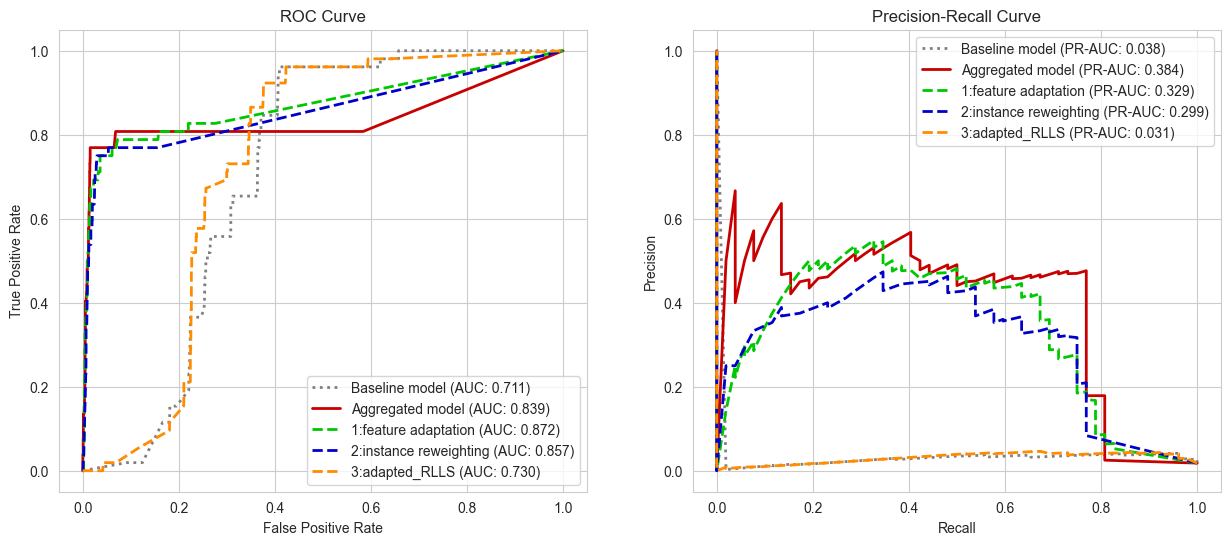

In [105]:
### Visualization of the results (ROC and pr-curves)
# Plot the resultings roc and precision-recall curves
# Create subplots: two plots horizontally aligned
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

dark_red = (200/255, 0/255, 0/255)
dark_green = (0/255, 200/255, 0/255)
dark_blue = (0/255, 0/255, 200/255)
dark_orange = (255/255, 140/255, 0/255)
light_grey = (128/255, 128/255, 128/255)


# ROC curves
ax1.plot(fpr_0, tpr_0, label=f'Baseline model (AUC: {roc_auc_0:.3f})', linestyle='dotted', linewidth=2, c = light_grey)
ax1.plot(fpr_4, tpr_4, label=f'Aggregated model (AUC: {roc_auc_4:.3f})', linestyle='-', linewidth=2, c = dark_red)
ax1.plot(fpr_1, tpr_1, label=f'1:feature adaptation (AUC: {roc_auc_1:.3f})', linestyle='--', linewidth=2, c = dark_green)
ax1.plot(fpr_2, tpr_2, label=f'2:instance reweighting (AUC: {roc_auc_2:.3f})', linestyle='--', linewidth=2, c = dark_blue)
ax1.plot(fpr_3, tpr_3, label=f'3:adapted_RLLS (AUC: {roc_auc_3:.3f})', linestyle='--', linewidth=2, c = dark_orange)

ax1.set_title('ROC Curve')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc='lower right')
ax1.grid(True)

# Precision-Recall curves
ax2.plot(recalls_0, precisions_0, label=f'Baseline model (PR-AUC: {pr_auc_0:.3f})', linestyle='dotted', linewidth=2, c = light_grey)
ax2.plot(recalls_4, precisions_4, label=f'Aggregated model (PR-AUC: {pr_auc_4:.3f})', linestyle='-', linewidth=2, c = dark_red)
ax2.plot(recalls_1, precisions_1, label=f'1:feature adaptation (PR-AUC: {pr_auc_1:.3f})', linestyle='--', linewidth=2, c = dark_green)
ax2.plot(recalls_2, precisions_2, label=f'2:instance reweighting (PR-AUC: {pr_auc_2:.3f})', linestyle='--', linewidth=2, c = dark_blue)
ax2.plot(recalls_3, precisions_3, label=f'3:adapted_RLLS (PR-AUC: {pr_auc_3:.3f})', linestyle='--', linewidth=2, c = dark_orange)


ax2.set_title('Precision-Recall Curve')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend(loc='upper right')
ax2.grid(True)

# Show the plot
plt.show()
